# University of Virginia
## DS 7200: Distributed Computing
## Final Project

### Team 5: Gia Smith, Luz Melo, Meesun Yang

---

In [1]:
import os
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, DateType, FloatType, LongType
from pyspark.sql import functions as F
import numpy as np
from pyspark.sql import SQLContext
from pyspark.sql.functions import lit
from pyspark.sql.functions import col
import matplotlib.pyplot as plt
from pyspark.sql.functions import mean, stddev, corr
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import GBTRegressor
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator

In [2]:
# Get the current working directory
current_directory = os.getcwd()

# Print the current working directory
print("Current Working Directory:", current_directory)
# List files in the current working directory
print("Files in Current Directory:", os.listdir())

Current Working Directory: /sfs/qumulo/qhome/czj9zj/Final Project
Files in Current Directory: ['KO_merged_data.csv', 'KO_1st_toLoad.csv', 'KO_quarterly_balance-sheet.csv', 'writeup.ipynb', 'KO_quarterly_valuation_measures.csv', 'KO_quarterly_financials.csv', 'KOv3.csv', 'KO_filtered_merged_data.csv', '.ipynb_checkpoints', 'KO.csv', 'filtered_merged_data.csv', 'KO_quarterly_cash-flow.csv']


In [3]:
# set up the session
spark = SparkSession.builder.getOrCreate()

/opt/conda/lib/python3.7/site-packages/pyspark/bin/load-spark-env.sh: line 68: ps: command not found
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/11/22 13:35:27 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [27]:
# Read in stock data. Source: Yahoo! finance
path1 = 'KO.csv'
path2 = 'KO_1st_toLoad.csv'
path3 = 'KO_quarterly_valuation_measures.csv'
path4 = 'KO_quarterly_financials.csv'
path5 = 'KO_quarterly_balance-sheet.csv'
path6 = 'KO_quarterly_cash-flow.csv'
path7 = 'KO_merged_data.csv'
path8 = 'filtered_merged_data.csv'
path9 = 'KO_filtered_merged_data.csv'
path10 = 'KOv3.csv'

### Historical Data

In [5]:
# set up schema
stock_schema = StructType([StructField('Date',DateType(),False),
                           StructField('Open',FloatType(),False),
                           StructField('High',FloatType(),False),
                           StructField('Low',FloatType(),False),
                           StructField('Close',FloatType(),False),
                           StructField('Adj Close',FloatType(),False),
                           StructField('Volume',LongType(),False),
                         ])

In [6]:
df1 = spark.read.csv(path1, header=True, schema=stock_schema)
df1.show(10)

+----------+--------+--------+--------+--------+---------+-------+
|      Date|    Open|    High|     Low|   Close|Adj Close| Volume|
+----------+--------+--------+--------+--------+---------+-------+
|1962-01-02|0.263021|0.270182|0.263021|0.263021| 0.048528| 806400|
|1962-01-03|0.259115|0.259115|0.253255|0.257161| 0.047447|1574400|
|1962-01-04|0.257813|0.261068|0.257813|0.259115| 0.047807| 844800|
|1962-01-05|0.259115| 0.26237|0.252604|0.253255| 0.046726|1420800|
|1962-01-08|0.251302|0.251302|0.245768|0.250651| 0.046246|2035200|
|1962-01-09|0.250651| 0.25651|0.248698|0.255208| 0.047087| 960000|
|1962-01-10|0.255208|0.260091|0.252604| 0.25651| 0.047327|1612800|
|1962-01-11| 0.25651|0.259115|0.255208|0.259115| 0.047807| 614400|
|1962-01-12|0.259115|0.259115|0.254557|0.257161| 0.047447| 883200|
|1962-01-15| 0.25651| 0.25651|0.253906|0.254557| 0.046966| 614400|
+----------+--------+--------+--------+--------+---------+-------+
only showing top 10 rows



In [7]:
df1.printSchema()

root
 |-- Date: date (nullable = true)
 |-- Open: float (nullable = true)
 |-- High: float (nullable = true)
 |-- Low: float (nullable = true)
 |-- Close: float (nullable = true)
 |-- Adj Close: float (nullable = true)
 |-- Volume: long (nullable = true)



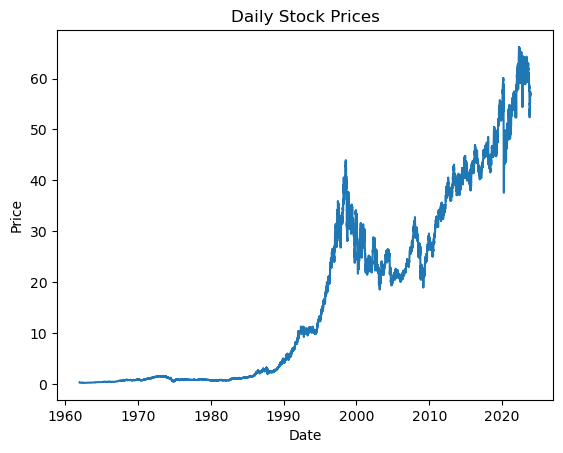

In [8]:
# Imports
import matplotlib.pyplot as plt

prices = df1.select("Date", "Close").collect()
dates = [row.Date for row in prices]
prices = [row.Close for row in prices]

plt.plot(dates, prices)
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Daily Stock Prices")
plt.show()

In [9]:
mean_price = df1.select(mean("Close")).first()[0]
stddev_price = df1.select(stddev("Close")).first()[0]
corr_price_volume = df1.select(corr("Close", "Volume")).first()[0]

print("Mean Price:", mean_price)
print("Standard Deviation Price:", stddev_price)
print("Correlation between Price and Volume:", corr_price_volume)

Mean Price: 17.44691300745597
Standard Deviation Price: 18.399699444096413
Correlation between Price and Volume: 0.4734944376203516


In [10]:
df1.describe().show()

+-------+------------------+------------------+------------------+------------------+------------------+------------------+
|summary|              Open|              High|               Low|             Close|         Adj Close|            Volume|
+-------+------------------+------------------+------------------+------------------+------------------+------------------+
|  count|             15578|             15578|             15578|             15578|             15578|             15578|
|   mean|17.443087905915117|17.584551596108934| 17.29806420616332| 17.44691300745597|12.287431249795091| 9212160.328668635|
| stddev| 18.39905733332124|18.532486456813324|18.260003923963637|18.399699444096413|15.744719260632824|7942933.4953253465|
|    min|          0.192708|          0.193359|          0.182292|          0.192057|          0.035927|             76800|
|    max|              67.0|              67.2|             65.72|             66.21|          63.31803|         124169000|
+-------

In [11]:
# register stock dataFrame as temp view with name "stocks"
df1.createOrReplaceTempView("stocks")

# query the view
sqlDF1 = spark.sql("SELECT * FROM stocks where Volume > 9212160")
sqlDF1.show()

+----------+--------+--------+--------+--------+---------+--------+
|      Date|    Open|    High|     Low|   Close|Adj Close|  Volume|
+----------+--------+--------+--------+--------+---------+--------+
|1962-03-01|0.238932|0.238932|0.234375| 0.23763| 0.043843|19545600|
|1969-06-13|0.747396| 0.75651|0.736979|0.744792| 0.162613| 9552000|
|1973-02-13| 1.53125|1.546875| 1.53125| 1.53125| 0.351657|11836800|
|1974-09-23| 0.71875| 0.71875| 0.65625| 0.65625| 0.155209|28022400|
|1974-09-25|   0.625|0.651042|0.606771|0.606771| 0.143507|10588800|
|1974-10-01|0.533854|0.559896|     0.5|0.549479| 0.129957| 9379200|
|1974-10-10|0.580729|0.617188|0.580729| 0.59375| 0.140427|10454400|
|1974-11-18|0.567708|0.567708|0.502604|0.509115|  0.12041|10771200|
|1974-12-17| 0.49349|0.520833|0.485677|0.520833| 0.124483|12134400|
|1975-02-07|0.753906|0.753906|0.736979|0.752604| 0.179878|10329600|
|1976-11-05| 0.84375|0.846354| 0.80599|0.811198| 0.204251|10108800|
|1976-12-20|0.782552|0.785156|0.765625|0.765625|

In [12]:
from pyspark.sql.functions import desc

# Assuming 'Date' and 'Volume' are column names in your DataFrame
max_volume_date = df1.orderBy(desc('Volume')).select('Date').first()['Date']

print(f"The date with the highest volume is: {max_volume_date}")

The date with the highest volume is: 2009-09-18


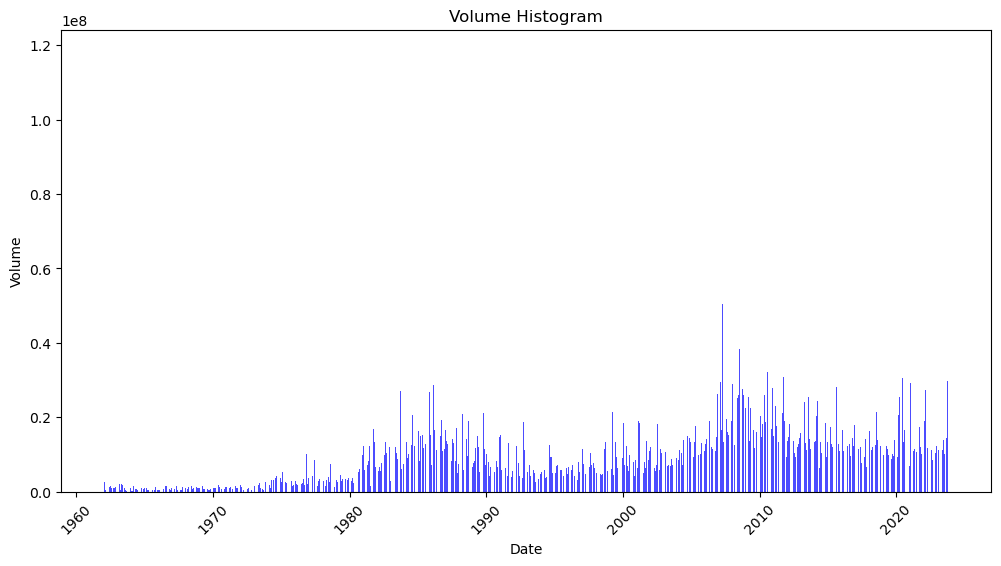

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert PySpark DataFrame to pandas DataFrame
df_pandas = df1.toPandas()

# Assuming 'Date' is a string, you can convert it to datetime with a specific format
df_pandas['Date'] = pd.to_datetime(df_pandas['Date'], format='%Y-%m-%d')

# Plotting the volume histogram
plt.figure(figsize=(12, 6))
plt.bar(df_pandas['Date'], df_pandas['Volume'], color='blue', alpha=0.7)
plt.title('Volume Histogram')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.xticks(rotation=45)

# Set a specific limit on the y-axis
plt.ylim(0, max(df_pandas['Volume']))  # Adjust the upper limit as needed

plt.show()

### Questions to Analyze Using PySpark

In this section, we will give answers to some questions data using PySpark’s data preprocessing technique

- On what day stock price was the highest?
- What is the average Closing price?
- What is the maximum and minimum volume of stock traded
- For how many days the closing value was less than 60 dollars?
- What could be the maximum high value for each year?

### Historical Data Filtered

In [14]:
df2 = spark.read.csv(path2, header=True, inferSchema=True)
df2.show(10)

#why does date comes null when we use stock_schema in this csv file?

+----------+--------+--------+--------+--------+---------+---------+
|      Date|    Open|    High|     Low|   Close|Adj Close|   Volume|
+----------+--------+--------+--------+--------+---------+---------+
| 3/31/1985|1.458333|1.505208|1.408854|1.427083| 0.565683|331833600|
| 6/30/1985|1.445313|1.559896|1.401042|1.505208| 0.603144|522912000|
| 9/30/1985|1.453125|1.510417|1.440104|1.492188| 0.604408|258590400|
|12/31/1985|1.760417|1.770833|1.598958|1.747396| 0.714215|288134400|
| 3/31/1986|  2.1875|     2.5|2.052083|2.322917| 0.957008|416294400|
| 6/30/1986|2.742188|2.804688|2.359375|2.445313| 1.014374|364022400|
| 9/30/1986|2.117188|2.453125|2.109375|2.289063| 0.956324|255110400|
|12/31/1986|2.359375|2.773438|2.359375|2.664063| 1.121004|392235200|
| 3/31/1987|2.859375|  2.9375|2.546875|2.664063| 1.128003|319137600|
| 6/30/1987|2.765625|2.992188|2.679688|2.976563| 1.268484|321331200|
+----------+--------+--------+--------+--------+---------+---------+
only showing top 10 rows



In [15]:
df2. printSchema()

root
 |-- Date: string (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- Adj Close: double (nullable = true)
 |-- Volume: integer (nullable = true)



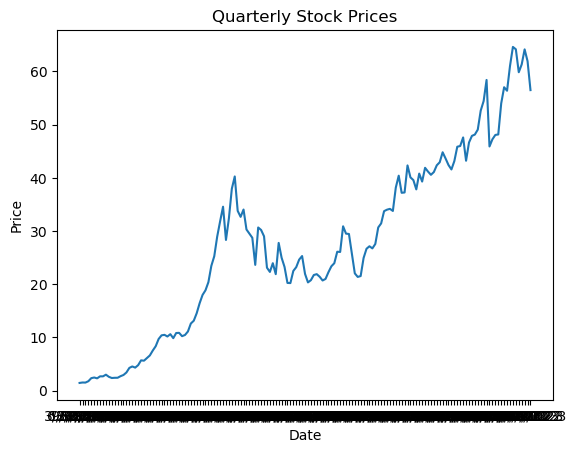

In [16]:
prices = df2.select("Date", "Close").collect()
dates = [row.Date for row in prices]
prices = [row.Close for row in prices]

plt.plot(dates, prices)
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Quarterly Stock Prices")
plt.show()

### Valuation Measures

In [17]:
df3 = spark.read.csv(path3, header=True, inferSchema=True)
df3.show(10)

+----------+---------------+---------------+-------+--------------+--------+-------+-------+----------------------------+---------------------------+
|      Date|      MarketCap|EnterpriseValue|PeRatio|ForwardPeRatio|PegRatio|PsRatio|PbRatio|EnterprisesValueRevenueRatio|EnterprisesValueEBITDARatio|
+----------+---------------+---------------+-------+--------------+--------+-------+-------+----------------------------+---------------------------+
|       ttm|247,558,674,760|272,294,674,760| 23.182|         20.45|   2.698|  5.522|  9.404|                       6.047|                     17.509|
| 9/30/2023|242,057,520,000|267,988,520,000| 23.228|        19.763|   2.582|  5.509|  9.305|                       22.42|                     63.883|
| 6/30/2023|260,391,280,000|288,496,280,000| 26.529|        23.202|   3.282|  6.019| 10.326|                      24.098|                     81.611|
| 3/31/2023|268,279,750,000|295,797,750,000| 28.324|        23.866|   3.378|  6.275|  11.13|        

### Income Statement

In [18]:
# set up the session
df4 = spark.read.csv(path4, header=True, inferSchema=True)
#df4.show(10)

### Balance Sheet

In [19]:
df5 = spark.read.csv(path5, header=True, inferSchema=True)
#df5.show(10)

### Cash Flow

In [20]:
df6 = spark.read.csv(path6, header=True, inferSchema=True)
#df6.show(10)

## Merge Datasets

In [21]:
merged_df = spark.read.csv(path7, header=True, inferSchema=True)
len(merged_df.columns)

214

### Cleaning Merged Dataset

In [22]:
filtered_merged_df = spark.read.csv(path8, header=True, inferSchema=True)
len(filtered_merged_df.columns)

102

### Join filtered Historical data and addtional data

In [23]:
df9 = spark.read.csv(path9, header=True, inferSchema=True)
len(df9.columns)

108

### Gradient-boosted Trees: Historical Data

In [24]:
feature_columns = df1.columns
feature_columns.remove('Adj Close')
feature_columns.remove('Date')

In [25]:
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')

# Split the data into training and testing sets
(training_data, testing_data) = df1.randomSplit([0.8, 0.2], seed=1234)

# Create a GBTRegressor
gbt = GBTRegressor(featuresCol='features', labelCol='Adj Close', maxDepth=5, maxBins=32, maxIter=20, seed=42)

# Create a pipeline
pipeline = Pipeline(stages=[assembler, gbt])

# Fit the model
model = pipeline.fit(training_data)

# Make predictions on the testing set
predictions = model.transform(testing_data)

# Evaluate the model
evaluator = RegressionEvaluator(labelCol="Adj Close", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE) on the test data: {rmse}")
# An aRMSE value close to 1 implies that the model's predictions have a high level of error relative to the range of the target variable.

Root Mean Squared Error (RMSE) on the test data: 1.2130441761449018


### Gradient-boosted Trees: KOv3 on Adj Close all columns

In [28]:
df10 = spark.read.csv(path10, header=True, inferSchema=True)

In [29]:
feature_columns = df10.columns
feature_columns.remove('Adj Close')
feature_columns.remove('Date')

In [34]:
# Convert the TaxEffectOfUnusualItems column from string to double 
df10 = df10.withColumn("TaxEffectOfUnusualItems", col("TaxEffectOfUnusualItems").cast("double"))

In [38]:
#df10. printSchema()

In [37]:
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features', handleInvalid="skip")

# Split the data into training and testing sets
(training_data, testing_data) = df10.randomSplit([0.8, 0.2], seed=1234)

training_data = training_data.na.drop()

# Create a GBTRegressor
gbt = GBTRegressor(featuresCol='features', labelCol='Adj Close', maxDepth=5, maxBins=32, maxIter=20, seed=42)

# Create a pipeline
pipeline = Pipeline(stages=[assembler, gbt])

# Fit the model
model = pipeline.fit(training_data)

# Make predictions on the testing set
predictions = model.transform(testing_data)

# Evaluate the model
evaluator = RegressionEvaluator(labelCol="Adj Close", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE) on the test data: {rmse}")
# An aRMSE value close to 1 implies that the model's predictions have a high level of error relative to the range of the target variable.

Root Mean Squared Error (RMSE) on the test data: 3.273395774607916


### Gradient-boosted Trees: KOv3 on Adj Close with subset of columns

In [43]:
features_columns = ['PeRatio','PsRatio','PbRatio','TotalRevenue','GrossProfit']

In [44]:
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features', handleInvalid="skip")

# Split the data into training and testing sets
(training_data, testing_data) = df10.randomSplit([0.8, 0.2], seed=1234)

training_data = training_data.na.drop()

# Create a GBTRegressor
gbt = GBTRegressor(featuresCol='features', labelCol='Adj Close', maxDepth=5, maxBins=32, maxIter=20, seed=42)

# Create a pipeline
pipeline = Pipeline(stages=[assembler, gbt])

# Fit the model
model = pipeline.fit(training_data)

# Make predictions on the testing set
predictions = model.transform(testing_data)

# Evaluate the model
evaluator = RegressionEvaluator(labelCol="Adj Close", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE) on the test data: {rmse}")
# An aRMSE value close to 1 implies that the model's predictions have a high level of error relative to the range of the target variable.

Root Mean Squared Error (RMSE) on the test data: 2.9465187724424524


### Gradient-boosted Trees: KOv3 on PercentChangeClose all columns

In [ ]:
feature_columns = df10.columns
feature_columns.remove('PercentChangeClose')
feature_columns.remove('Date')

In [39]:
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features', handleInvalid="skip")

# Split the data into training and testing sets
(training_data, testing_data) = df10.randomSplit([0.8, 0.2], seed=1234)

training_data = training_data.na.drop()

# Create a GBTRegressor
gbt = GBTRegressor(featuresCol='features', labelCol='PercentChangeClose', maxDepth=5, maxBins=32, maxIter=20, seed=42)

# Create a pipeline
pipeline = Pipeline(stages=[assembler, gbt])

# Fit the model
model = pipeline.fit(training_data)

# Make predictions on the testing set
predictions = model.transform(testing_data)

# Evaluate the model
evaluator = RegressionEvaluator(labelCol="PercentChangeClose", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE) on the test data: {rmse}")
# An aRMSE value close to 1 implies that the model's predictions have a high level of error relative to the range of the target variable.

Root Mean Squared Error (RMSE) on the test data: 0.043364899711974776


### Gradient-boosted Trees: KOv3 on PercentChangeClose with subset of columns

In [41]:
features_columns = ['PeRatio','PsRatio','PbRatio','TotalRevenue','GrossProfit']

In [42]:
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features', handleInvalid="skip")

# Split the data into training and testing sets
(training_data, testing_data) = df10.randomSplit([0.8, 0.2], seed=1234)

training_data = training_data.na.drop()

# Create a GBTRegressor
gbt = GBTRegressor(featuresCol='features', labelCol='PercentChangeClose', maxDepth=5, maxBins=32, maxIter=20, seed=42)

# Create a pipeline
pipeline = Pipeline(stages=[assembler, gbt])

# Fit the model
model = pipeline.fit(training_data)

# Make predictions on the testing set
predictions = model.transform(testing_data)

# Evaluate the model
evaluator = RegressionEvaluator(labelCol="PercentChangeClose", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE) on the test data: {rmse}")
# An aRMSE value close to 1 implies that the model's predictions have a high level of error relative to the range of the target variable.

Root Mean Squared Error (RMSE) on the test data: 0.07415345470557937
